# Back-testing

> Modelo optimizado, evaluado en un semillerio

> Modelo semillerio de Denicolay

In [ ]:
# Librerias
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#######
# rutas
# datasets
from config import dataset_file_fe6_6xxpqt
# optimizacion
from config import db_path
# modelos
from config import modelos_path
# predicciones
from config import pred_path

##########
# pipeline
from processing import ModelPipeline, plot_comparisons_on_kaggle_split
from processing import analyze_study
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import optuna
import warnings

# Ignorar advertencias de tipo UserWarning
warnings.filterwarnings('ignore', category=UserWarning, module='pandas')
warnings.filterwarnings('ignore', category=Warning, module='lightgbm')
warnings.filterwarnings('ignore', category=UserWarning, module='lightgbm')

/home/santtedo/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Variables de train y test

In [12]:
ganancia_acierto = 273000
costo_estimulo = 7000

mes_train_all = [201901, 201902, 201903, 201904, 201905, 201906, 201907, 201908,
                 201909, 201910, 201911, 201912, 202001, 202002, 202003, 202004,
                 202005, 202006, 202007, 202008, 202009, 202010, 202011, 202012,
                 202101, 202102, 202103, 202104, 202105, 202106, 202107]

mes_train_ult_3_meses = [202105, 202106, 202107]

mes_train_ult_6_meses = [202102, 202103, 202104, 202105, 202106, 202107]

mes_train_ult_9_meses = [202010, 202011, 202012, 202101, 202102, 202103, 202104, 202105, 202106, 202107]

mes_train_ult_anio = [202007, 202008, 202009, 202010, 202011, 202012,
                 202101, 202102, 202103, 202104, 202105, 202106, 202107]

mes_train = [202107]
mes_test = 202109

threshold = 0.025

semillas = [437809, 327347, 392879, 455783, 217163]

## Loading data

In [ ]:
data = pd.read_parquet(dataset_file_fe6_6xxpqt) 

# Mapear etiquetas de clase a números
label_mapping = {'CONTINUA': 0, 'BAJA+1': 1, 'BAJA+2': 2}

data['clase_ternaria'] = data['clase_ternaria'].map(label_mapping)

# Simulación para Kaggle
mes_bt_ult_anio = [202008, 202009, 202010, 202011, 202012,
                 202101, 202102, 202103, 202104, 202105]

X_train = data[data['foto_mes'].isin(mes_bt_ult_anio)]
y_train = X_train['clase_ternaria']
X_train = X_train.drop(columns=['clase_ternaria'])

mes_futuro = 202107 # usado como test
X_test = data[data['foto_mes'] == mes_futuro]
y_test = X_test['clase_ternaria']
X_test = X_test.drop(columns=['clase_ternaria'])

del data

Preprocesando data

In [14]:
# Imputacion de Xs
cols_with_all_nan = X_train.columns[X_train.isna().all()].tolist()
print("Columns with all NaN values:", cols_with_all_nan)
X_train = X_train.drop(columns=cols_with_all_nan)
X_test = X_test.drop(columns=cols_with_all_nan)

# Imputación de nulls
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
X_train_imp = pd.DataFrame(imp_median.fit_transform(X_train), columns=X_train.columns)
X_test_imp = pd.DataFrame(imp_median.transform(X_test), columns=X_train.columns)

del X_train
del X_test

# Codificar variables categóricas
categorical_features = [col for col in X_train_imp.columns if X_train_imp[col].dtype == 'object']

# Convertir variables categóricas a 'category' dtype para LightGBM
for col in categorical_features:
    X_train_imp[col] = X_train_imp[col].astype('category')
    X_test_imp[col] = X_test_imp[col].astype('category')

Columns with all NaN values: ['payroll_slope_1_foto_mes', 'cuenta_corriente_slope_1_foto_mes', 'visa_consumo_slope_1_foto_mes', 'comisiones_mantenimiento_slope_1_foto_mes', 'comisiones_otras_slope_1_foto_mes']


Función de ganancia

In [15]:
def ganancia(y, y_hat, thr, 
             ganancia_acierto = ganancia_acierto, 
             costo_estimulo = costo_estimulo,
             target = 2, prop=1):

    # Calcular la ganancia para cada fila
    gains = np.where(y_hat >= thr, np.where(y == target, ganancia_acierto, -costo_estimulo), 0)

    # Sumar las ganancias
    estimated_gain = gains.sum()/prop

    return estimated_gain

## Modelos candidatos

Luego de una comparación de modelos candidatos en comp03_lastdacexx

Se decide optar como **modelo optimizado** el:

> **lgbm prepro6 fe6 y 12 opt (local opt)**

Mientras que, para calcular una predicción con semillerío:

> **semillero de Denicolay**

semillerio_params = {'n_estimators': 23,
                  'num_leaves': 32,
                  'learning_rate': 0.34,
                  'min_data_in_leaf': 711,
                  'feature_fraction': 0.2,
                  'extra_trees': False,
                  'random_state': semillas[s],
}

## Evaluación de semillerios 

Que incluya una nuevaa evaluación del punto de corte

Aparte del hecho en comp03_back-testing, que ya sugiere el umbral óptimo

Entrenamiento con óptimos parámetros

**Modelo optimizado** para comp03

Con las distintas semillas

Para datos xx, con lag2 y delta2

In [ ]:
from lightgbm import LGBMClassifier

# Tomando al mejor modelo optimizado

prepro = 6 # data quality + data drifting
fe = 6 # feature engineering conceptual 6 meses
training = 3 # un mes de optimización

storage_name = "sqlite:///" + db_path + "optimization_tree.db"
# carga local
# storage_name = "sqlite:///optimizacion/optimization_tree.db"
study_name = f"exp_lgbm_comp03_local_v00"

study = optuna.load_study(study_name=study_name, storage=storage_name)

# Mejores parámetros
opt_params = study.best_trial.params
opt_params.update({'n_jobs': -1})

print("Running back-testing for LGBMClassifier Opt")
print(opt_params)

# para registrar las probabilidades
df_s_proba = pd.DataFrame({
                            'client': y_test.index,
                            'baja': y_test.values,
                        })

label_antimapping = {0:'CONTINUA', 1:'BAJA+1', 2:'BAJA+2'}
df_s_proba['clase_ternaria'] = df_s_proba['baja'].map(label_antimapping)

df_lgbm_semillerios = pd.DataFrame()

semillerio = []
l_max_gan = []
l_max_gan_thr = []
l_max_gan_esti = []

i = 0
r_sem = range(217163, 455783, 7*7*7*7*100) # 1 semillerio
sem_total = len(list(range(217163, 455783, 7*7*7*7*100)))
r_s = range(217163, 455783, 7*7*7*7*10) # 10 semillas
s_total = len(list(range(217163, 455783, 7*7*7*7*10)))

for sem in r_sem:
    print(f"\n\n# Semillerio: {sem}, {i+1} de {sem_total}")

    # para operar sobre el semillerio
    df_s = df_s_proba

    j = 0
    for s in r_s:
        # nueva instancia del modelos con semilla
        seed = s+(7+j)**i
        model = LGBMClassifier(**opt_params, random_state=seed)
        # entreno
        print(f"\nEntrenando modelo con semilla: {seed}, {j+1} de {s_total}")
        model.fit(X_train_imp, y_train)
        # predigo proba
        y_pred_proba = model.predict_proba(X_test_imp)
        # proba baja+2
        proba_baja2 = y_pred_proba[:,2]
        df_s[f'proba_s{seed}'] = proba_baja2
        j += 1

    # calculando proba mean
    proba_s_columns = df_s.filter(regex='^proba_s')
    proba_s_mean = proba_s_columns.mean(axis=1)

    df_s['proba_sem_mean'] = proba_s_mean  

    # dataframe con el test
    test_results = pd.DataFrame({
                            'client': y_test.index,
                            'baja': y_test.values,
                            'proba_sem_baja2' : df_s['proba_sem_mean'].values
                        })
    test_results['clase_ternaria'] = test_results['baja'].map(label_antimapping)

    # ganancias según threshold
    thrs = []
    ganancias = []
    estimulos = []
    for thr in np.linspace(0.01, 0.03, 1000):
        gain = ganancia(test_results.baja, test_results.proba_sem_baja2, thr)
        esti = np.where(test_results.proba_sem_baja2 >= thr, 1, 0).sum()
        thrs.append(thr)
        ganancias.append(gain)
        estimulos.append(esti)
            
    df_lgbm_semillerios[f'threshold'] = thrs # será siempre igual
    df_lgbm_semillerios[f'ganancias_{sem}'] = ganancias # 
    df_lgbm_semillerios[f'estimulos_{sem}'] = estimulos # 

    # maxima ganancia y condiciones
    max_gan_idx = df_lgbm_semillerios[f'ganancias_{sem}'].idxmax()
    max_gan_thr = df_lgbm_semillerios['threshold'][max_gan_idx]
    max_gan = df_lgbm_semillerios[f'ganancias_{sem}'][max_gan_idx]
    max_estimulos = df_lgbm_semillerios[f'estimulos_{sem}'][max_gan_idx]
        
    print(f"sem: {sem}, ganancia max: {max_gan}, thr: {max_gan_thr}, estimulos: {max_estimulos}")
    
    # registro condiciones de maxima para summary
    semillerio.append(sem)
    l_max_gan_thr.append(max_gan_thr)
    l_max_gan.append(max_gan)
    l_max_gan_esti.append(max_estimulos)

    i += 1

df_lgbm_semillerios_summary = pd.DataFrame({
                            'semillerio': semillerio,
                            'thr_max_gan': l_max_gan_thr,
                            'max_gan': l_max_gan,
                            'est_max_gan': l_max_gan_esti,
                        })

Running back-testing for LGBMClassifier Opt
{'n_estimators': 532, 'num_leaves': 74, 'learning_rate': 0.02597037622291732, 'min_data_in_leaf': 160, 'feature_fraction': 0.5306395912844186, 'n_jobs': -1}


# Semillerio: 217163, 1 de 5

Entrenando modelo con semilla: 217164, 1 de 10
[LightGBM] [Warning] min_data_in_leaf is set=160, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=160
[LightGBM] [Warning] feature_fraction is set=0.5306395912844186, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5306395912844186
[LightGBM] [Warning] min_data_in_leaf is set=160, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=160
[LightGBM] [Warning] feature_fraction is set=0.5306395912844186, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5306395912844186
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 6.467521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[L

Análisis del semillerio

In [19]:
df_lgbm_semillerios.head()

,threshold,ganancias_217163,estimulos_217163,ganancias_265183,estimulos_265183,ganancias_313203,estimulos_313203,ganancias_361223,estimulos_361223,ganancias_409243,estimulos_409243
0,0.01000,159446000.0,16542,160944000.0,16568,161063000.0,16551,160944000.0,16568,160230000.0,16550
1,0.01002,159614000.0,16518,161147000.0,16539,160930000.0,16530,161049000.0,16553,160384000.0,16528
2,0.01004,159705000.0,16505,161245000.0,16525,160818000.0,16506,161238000.0,16526,160538000.0,16506
3,0.01006,159579000.0,16483,161371000.0,16507,160951000.0,16487,161371000.0,16507,160111000.0,16487
4,0.01008,159453000.0,16461,161504000.0,16488,161091000.0,16467,161203000.0,16491,160209000.0,16473


In [20]:
df_lgbm_semillerios_summary.head()

,semillerio,thr_max_gan,max_gan,est_max_gan
0,217163,0.015305,165823000.0,12111
1,265183,0.016627,165620000.0,11340
2,313203,0.017427,165844000.0,10908
3,361223,0.017508,165529000.0,10873
4,409243,0.017487,165431000.0,10887


In [ ]:
df_lgbm_semillerios.to_csv(pred_path+'df_lgbm_semilleriosxx.csv')

In [ ]:
df_lgbm_semillerios_summary.to_csv(pred_path+'df_lgbm_semillerios_summaryxx.csv')

Visualización

In [23]:
def plot_ganancias_estimulos(df_sem):
    fig, ax1 = plt.subplots()

    # Iterar sobre cada columna de ganancias y estimulos
    for sem in df_sem.columns:
        if sem.startswith('ganancias_'):
            ganancias = df_sem[sem]
            threshold = df_sem['threshold']
            
            # Plot A: Threshold vs Ganancias in gray
            ax1.plot(threshold, ganancias, color='gray')

    # Calcular y graficar las ganancias y estímulos promedio
    ganancias_avg = df_sem[[col for col in df_sem.columns if col.startswith('ganancias_')]].mean(axis=1)
    estimulos_avg = df_sem[[col for col in df_sem.columns if col.startswith('estimulos_')]].mean(axis=1)
    
    # Plot average in black
    ax1.plot(threshold, ganancias_avg, label='Ganancias Promedio', color='black', linestyle='--')

    # Highlight maximum gain
    max_gain_idx = ganancias_avg.idxmax()
    max_gain_threshold = threshold[max_gain_idx]
    max_gain = max(ganancias_avg)
    max_estimulos = estimulos_avg[max_gain_idx]

    ax1.scatter(max_gain_threshold, max_gain, color='red', zorder=5)
    ax1.annotate(f"Max Gain: {max_gain}\nThresh: {max_gain_threshold:.3f}\nEstim: {max_estimulos}", 
                (max_gain_threshold, max_gain), textcoords="offset points", xytext=(0,-20), ha='center')

    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('Ganancias')
    ax1.legend()
    plt.title('Ganancias vs Threshold para cada Semillerio')
    plt.show()

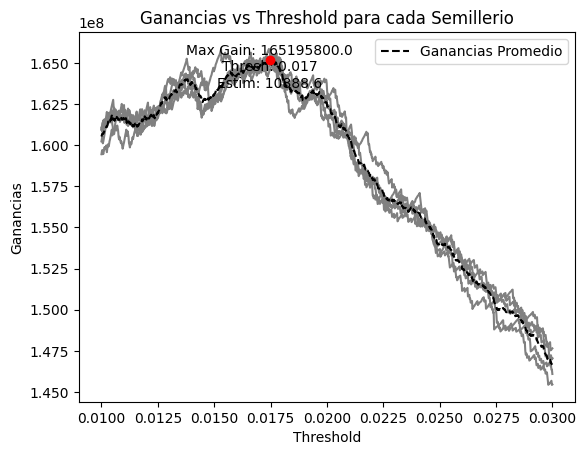

In [24]:
plot_ganancias_estimulos(df_lgbm_semillerios)

**Modelo semillerio**

Con las distintas semillas, según Denicolay

In [18]:
len(list(range(217163, 455783, 7*7*7*6)))

116

In [ ]:
from lightgbm import LGBMClassifier

semillero_params = {'n_estimators': 23,
                  'num_leaves': 32,
                  'learning_rate': 0.34,
                  'min_data_in_leaf': 711,
                  'feature_fraction': 0.25,
                  'extra_trees': False,
}

semillero_params.update({'n_jobs': -1})

print("Running back-testing for Semillerio Denicolay")
print(semillero_params)

# para registrar las probabilidades
df_s_proba = pd.DataFrame({
                            'client': y_test.index,
                            'baja': y_test.values,
                        })

label_antimapping = {0:'CONTINUA', 1:'BAJA+1', 2:'BAJA+2'}
df_s_proba['clase_ternaria'] = df_s_proba['baja'].map(label_antimapping)

df_semillerios = pd.DataFrame()

semillerio = []
l_max_gan = []
l_max_gan_thr = []
l_max_gan_esti = []

i = 0
r_sem = range(217163, 455783, 7*7*7*7*100) # 1 semillerio
sem_total = len(list(range(217163, 455783, 7*7*7*7*100)))
r_s = range(217163, 455783, 7*7*7*6) # 116 semillas
s_total = len(list(range(217163, 455783, 7*7*7*6)))

for sem in r_sem:
    print(f"\n\n# Semillerio: {sem}, {i+1} de {sem_total}")

    # para operar sobre el semillerio
    df_s = df_s_proba

    j = 0
    for s in r_s:
    #for s in range(0,2):
        # nueva instancia del modelos con semilla
        seed = s+(7+j)**i
        model = LGBMClassifier(**semillero_params, random_state=seed)
        # entreno
        print(f"\nEntrenando modelo con semilla: {seed}, {j+1} de {s_total}")
        model.fit(X_train_imp, y_train)
        # predigo proba
        y_pred_proba = model.predict_proba(X_test_imp)
        # proba baja+2
        proba_baja2 = y_pred_proba[:,2]
        df_s[f'proba_s{seed}'] = proba_baja2
        j += 1
    
    # calculando proba mean
    proba_s_columns = df_s.filter(regex='^proba_s')
    proba_s_mean = proba_s_columns.mean(axis=1)

    df_s['proba_sem_mean'] = proba_s_mean  

    # dataframe con el test
    test_results = pd.DataFrame({
                            'client': y_test.index,
                            'baja': y_test.values,
                            'proba_sem_baja2' : df_s['proba_sem_mean'].values
                        })
    test_results['clase_ternaria'] = test_results['baja'].map(label_antimapping)

    # ganancias según threshold
    thrs = []
    ganancias = []
    estimulos = []
    for thr in np.linspace(0.01, 0.03, 1000):
        gain = ganancia(test_results.baja, test_results.proba_sem_baja2, thr)
        esti = np.where(test_results.proba_sem_baja2 >= thr, 1, 0).sum()
        thrs.append(thr)
        ganancias.append(gain)
        estimulos.append(esti)
            
    df_semillerios[f'threshold'] = thrs # será siempre igual
    df_semillerios[f'ganancias_{sem}'] = ganancias # 
    df_semillerios[f'estimulos_{sem}'] = estimulos # 

    # maxima ganancia y condiciones
    max_gan_idx = df_semillerios[f'ganancias_{sem}'].idxmax()
    max_gan_thr = df_semillerios['threshold'][max_gan_idx]
    max_gan = df_semillerios[f'ganancias_{sem}'][max_gan_idx]
    max_estimulos = df_semillerios[f'estimulos_{sem}'][max_gan_idx]
        
    print(f"sem: {sem}, ganancia max: {max_gan}, thr: {max_gan_thr}, estimulos: {max_estimulos}")
    
    # registro condiciones de maxima para summary
    semillerio.append(sem)
    l_max_gan_thr.append(max_gan_thr)
    l_max_gan.append(max_gan)
    l_max_gan_esti.append(max_estimulos)

    i += 1

df_semillerios_summary = pd.DataFrame({
                            'semillerio': semillerio,
                            'thr_max_gan': l_max_gan_thr,
                            'max_gan': l_max_gan,
                            'est_max_gan': l_max_gan_esti,
                        })

Running back-testing for Semillerio Denicolay
{'n_estimators': 23, 'num_leaves': 32, 'learning_rate': 0.34, 'min_data_in_leaf': 711, 'feature_fraction': 0.2, 'extra_trees': False, 'n_jobs': -1}


# Semillerio: 217163, 1 de 10

Entrenando modelo con semilla: 217164, 1 de 25
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.440238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Lig

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.460859 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86140
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.461952 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86269
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.457136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 85939
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 655
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


sem: 289193, ganancia max: 167055000.0, thr: 0.017207207207207205, estimulos: 11695


# Semillerio: 313203, 5 de 10

Entrenando modelo con semilla: 219564, 1 de 25
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.467704 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86230
[LightGBM] [Info] Number of data points in the train set: 1614498, number of us

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.452721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86166
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.453946 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86143
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.961304 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86090
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.484589 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 85971
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.466711 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 85983
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 655
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.468320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86070
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.507781 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86119
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.456361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86046
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 655
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.472724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86133
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.480444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86097
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.547160 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86051
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.463474 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86043
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.537376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86172
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.487319 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86195
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 655
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.492723 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86046
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 655
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.469842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86114
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.468757 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86061
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.476893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86238
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.497747 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86089
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.463471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86007
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 655
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.463625 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86131
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 655
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.455848 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86036
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.490029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86011
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 655
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.507327 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86059
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


sem: 313203, ganancia max: 167566000.0, thr: 0.016506506506506508, estimulos: 12182


# Semillerio: 337213, 6 de 10

Entrenando modelo con semilla: 233970, 1 de 25
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.484972 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86099
[LightGBM] [Info] Number of data points in the train set: 1614498, number of us

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.913705 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86090
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 655
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.490350 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 85985
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 655
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.462228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 85984
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 655
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.479624 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86141
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.493905 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86182
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.452960 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86188
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.461774 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86047
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.470749 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86182
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.464328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86179
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.466824 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86091
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.476207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86229
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.549295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86209
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.466587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86126
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.466423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86104
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.483981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86198
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.455095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86053
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.531872 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86025
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 653
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.478857 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86059
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.145938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86149
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.474570 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 85977
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.468413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86126
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.460605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86167
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 655
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.456094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86048
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.485821 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86109
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 655
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


sem: 337213, ganancia max: 166768000.0, thr: 0.016586586586586585, estimulos: 12176


# Semillerio: 361223, 7 de 10

Entrenando modelo con semilla: 334812, 1 de 25
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.443654 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86262
[LightGBM] [Info] Number of data points in the train set: 1614498, number of us

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.476106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86142
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.463626 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86080
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.473645 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86142
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 655
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.491048 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86195
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.511345 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86084
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.458796 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86073
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 655
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.534023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86059
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.456616 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86040
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.491970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86075
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 655
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.546824 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86171
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.479524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86094
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.457721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86094
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.464139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86146
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.485186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86143
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.498287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86109
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 655
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.472283 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86098
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 655
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.461649 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86083
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.459686 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86062
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.467907 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86049
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.478768 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86138
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.471991 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 85971
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 655
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.475207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86110
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.481092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86149
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 655
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.497984 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 85926
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


sem: 361223, ganancia max: 167188000.0, thr: 0.015365365365365365, estimulos: 12996


# Semillerio: 385233, 8 de 10

Entrenando modelo con semilla: 1040706, 1 de 25
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.462242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86084
[LightGBM] [Info] Number of data points in the train set: 1614498, number of u

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.450871 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86107
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.474723 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86257
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.467752 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 85983
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 655
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.502008 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86202
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.455085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86161
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.471967 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86127
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.475759 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86148
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.455833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86194
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.464486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 85949
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 655
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.480929 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86062
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.481322 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86049
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 655
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.451465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86224
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.454093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 85980
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 655
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.483667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 85990
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.462166 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86032
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 655
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.476706 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86152
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.464695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86204
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.468175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86180
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.482172 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86078
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.519135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86012
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.469567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86167
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.465297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86174
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.525389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86014
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 655
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.472770 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86054
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


sem: 385233, ganancia max: 167643000.0, thr: 0.016746746746746748, estimulos: 12051


# Semillerio: 409243, 9 de 10

Entrenando modelo con semilla: 5981964, 1 de 25
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.469217 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86050
[LightGBM] [Info] Number of data points in the train set: 1614498, number of u

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.484624 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86359
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.489885 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 85981
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 655
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.454109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86180
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.473791 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86037
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 655
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.460881 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86055
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.475463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86133
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.483483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86123
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.452366 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86083
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.476850 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86142
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.473439 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86043
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 655
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.477428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86001
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.488630 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86129
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.510250 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86182
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.500117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86122
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.507393 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86095
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.448356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86029
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 655
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.488609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86184
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.487219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86038
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 655
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.476980 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 85963
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 655
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.461373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86148
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.477289 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86093
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 655
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.452817 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86055
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 655
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.460603 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86174
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.476109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86187
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


sem: 409243, ganancia max: 167622000.0, thr: 0.016306306306306306, estimulos: 12334


# Semillerio: 433253, 10 de 10

Entrenando modelo con semilla: 40570770, 1 de 25
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.499802 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86203
[LightGBM] [Info] Number of data points in the train set: 1614498, number of

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.460044 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86167
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.473558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86133
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.534139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 85871
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 655
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.489490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86176
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.473336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86157
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.452197 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86138
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.459822 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86082
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 655
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.481235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86072
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.465110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86142
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.452512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86171
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.483525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86249
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.478284 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86241
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.487437 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86003
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 655
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.475979 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86075
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 655
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.485760 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86170
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 654
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.480516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86126
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.476392 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 85998
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 653
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.460625 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86149
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.459625 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86130
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.470028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86114
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.467311 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86046
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.468576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86051
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 655
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.462931 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86192
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.469376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86090
[LightGBM] [Info] Number of data points in the train set: 1614498, number of used features: 656
[LightGBM] [Info] Start training from score -0.009347
[LightGBM] [Info] Start training from score -5.394395
[LightGBM] [Info] Start training from s

/tmp/ipykernel_6708/1906271144.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s[f'proba_s{seed}'] = proba_baja2


sem: 433253, ganancia max: 168084000.0, thr: 0.017047047047047046, estimulos: 11868


In [26]:
df_semillerios.head()

,threshold,ganancias_217163,estimulos_217163,ganancias_241173,estimulos_241173,ganancias_265183,estimulos_265183,ganancias_289193,estimulos_289193,ganancias_313203,...,ganancias_337213,estimulos_337213,ganancias_361223,estimulos_361223,ganancias_385233,estimulos_385233,ganancias_409243,estimulos_409243,ganancias_433253,estimulos_433253
0,0.01000,153643000.0,17731,151200000.0,17960,153188000.0,18036,153433000.0,18121,153363000.0,...,153650000.0,18210,152439000.0,18263,154280000.0,18200,152999000.0,18183,153188000.0,18196
1,0.01002,153888000.0,17696,151095000.0,17935,153398000.0,18006,153041000.0,18097,153251000.0,...,153853000.0,18181,152656000.0,18232,154455000.0,18175,153125000.0,18165,153321000.0,18177
2,0.01004,154070000.0,17670,151249000.0,17913,153587000.0,17979,153251000.0,18067,153160000.0,...,153790000.0,18150,152754000.0,18218,154665000.0,18145,153279000.0,18143,153538000.0,18146
3,0.01006,153986000.0,17642,151487000.0,17879,153181000.0,17957,153139000.0,18043,153307000.0,...,153958000.0,18126,152992000.0,18184,154840000.0,18120,153426000.0,18122,153762000.0,18114
4,0.01008,153881000.0,17617,151431000.0,17847,153384000.0,17928,153055000.0,18015,153237000.0,...,153867000.0,18099,153118000.0,18166,155064000.0,18088,153594000.0,18098,153475000.0,18075


In [27]:
df_semillerios_summary.head()

,semillerio,thr_max_gan,max_gan,est_max_gan
0,217163,0.016386,159999000.0,11903
1,241173,0.015546,165935000.0,12615
2,265183,0.015626,165340000.0,12620
3,289193,0.017207,167055000.0,11695
4,313203,0.016507,167566000.0,12182


In [ ]:
df_semillerios.to_csv(pred_path+'df_profe_semillerios_03xx.csv')

In [ ]:
df_semillerios_summary.to_csv(pred_path+'df_profe_semillerios_summary_03xx.csv')

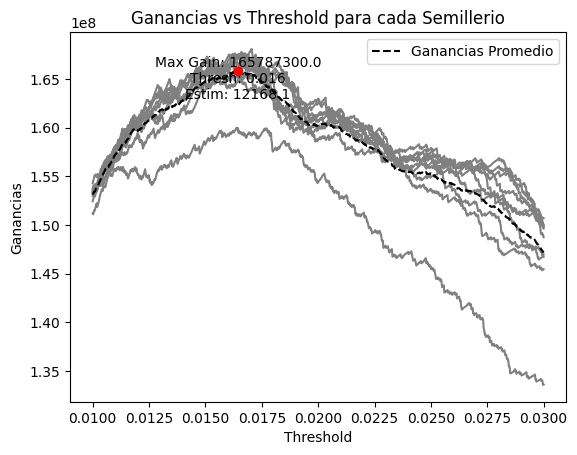

In [30]:
plot_ganancias_estimulos(df_semillerios)

### Comparación de semillerios

Con métodos visuales

In [36]:
def plot_ganancias_todas_superpuestas(df_sem1, df_sem2):
    fig, ax1 = plt.subplots()

    # Colores y nombres para cada modelo
    colores = ['blue', 'green']
    modelos = [df_sem1, df_sem2]
    nombres_modelos = ['lgbm sem', 'denicolay sem']

    for i, df_sem in enumerate(modelos):
        color = colores[i]
        nombre_modelo = nombres_modelos[i]
        
        # Obtener el threshold
        threshold = df_sem['threshold']
        
        # Graficar ganancias individuales
        for sem in df_sem.columns:
            if sem.startswith('ganancias_'):
                ganancias = df_sem[sem]
                ax1.plot(threshold, ganancias, color=color, alpha=0.1)
        
        # Calcular y graficar las ganancias promedio
        ganancias_cols = [col for col in df_sem.columns if col.startswith('ganancias_')]
        ganancias_avg = df_sem[ganancias_cols].mean(axis=1)
        ax1.plot(threshold, ganancias_avg, label=f'Ganancias Promedio {nombre_modelo}', color=color, linewidth=2)
        
        # Destacar la ganancia máxima
        max_gain_idx = ganancias_avg.idxmax()
        max_gain_threshold = threshold.iloc[max_gain_idx]
        max_gain = ganancias_avg.iloc[max_gain_idx]
        
        ax1.scatter(max_gain_threshold, max_gain, color=color, zorder=5)
        ax1.annotate(f"Max Gain {nombre_modelo}: {max_gain:.2f}\nThresh: {max_gain_threshold:.3f}", 
                    (max_gain_threshold, max_gain), textcoords="offset points", xytext=(0,-20*(i+1)), ha='center', color=color)

    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('Ganancias')
    ax1.legend()
    plt.title('Comparación de Ganancias vs Threshold entre Modelos')
    plt.show()

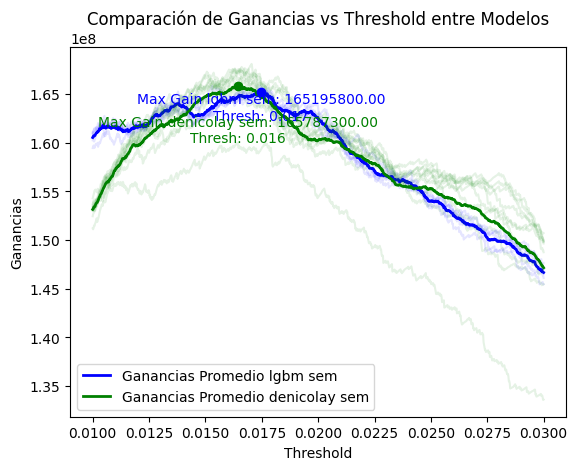

In [38]:
plot_ganancias_todas_superpuestas(df_lgbm_semillerios, df_semillerios)

In [35]:
def plot_ganancias_promedio_superpuestas(df_sem1, df_sem2):
    fig, ax1 = plt.subplots()

    # Colores y nombres para cada modelo
    colores = ['blue', 'green']
    modelos = [df_sem1, df_sem2]
    nombres_modelos = ['lgbm sem', 'denicolay sem']

    for i, df_sem in enumerate(modelos):
        color = colores[i]
        nombre_modelo = nombres_modelos[i]
        
        # Obtener el threshold
        threshold = df_sem['threshold']
        
        # Calcular las ganancias promedio
        ganancias_cols = [col for col in df_sem.columns if col.startswith('ganancias_')]
        ganancias_avg = df_sem[ganancias_cols].mean(axis=1)
        
        # Graficar las ganancias promedio
        ax1.plot(threshold, ganancias_avg, label=f'Ganancias Promedio {nombre_modelo}', color=color)
        
        # Destacar la ganancia máxima
        max_gain_idx = ganancias_avg.idxmax()
        max_gain_threshold = threshold.iloc[max_gain_idx]
        max_gain = ganancias_avg.iloc[max_gain_idx]
        
        ax1.scatter(max_gain_threshold, max_gain, color=color, zorder=5)
        ax1.annotate(f"Max Gain {nombre_modelo}: {max_gain:.2f}\nThresh: {max_gain_threshold:.3f}", 
                    (max_gain_threshold, max_gain), textcoords="offset points", xytext=(0,-20*(i+1)), ha='center', color=color)

    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('Ganancias Promedio')
    ax1.legend()
    plt.title('Comparación de Ganancias Promedio vs Threshold entre Modelos')
    plt.show()

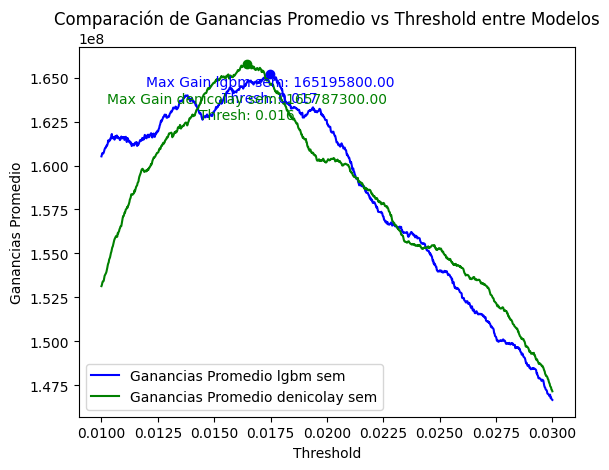

In [37]:
plot_ganancias_promedio_superpuestas(df_lgbm_semillerios, df_semillerios)

______